In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

## Ucitavanje podataka

In [2]:
# url kako se ne bi trebalo skidati lokalno csv file, vec se moze direktno skinuti s github-a (korisno za google colab)
URL_PODATAKA = 'https://raw.githubusercontent.com/laconlab/lacon-workshop-2021/main/podaci.csv'
podaci = pd.read_csv(URL_PODATAKA)
podaci.head()

,rijec,klasa
0,posvijetli,0
1,spektakularniju,0
2,monogamist,1
3,prijavu,0
4,fotografiravši,0


klasa 0 oznacava hrvatsku rijec, a kalasa 1 oznacava englesku rijec

## Higijena podataka

In [3]:
# odvajanje skupova za ucenje i testiranje
rijeci_ucenje, rijeci_test, klase_ucenje, klase_test =\
    train_test_split(
    podaci['rijec'],
    podaci['klasa'],
    test_size=0.2
)

detaljnije o funkciji train_test_split na [sluzbenoj dokumentaciji](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) gdje su i objasnjeni parametri poput random_state i test_size

podaci za testiranje se ne diraju sve do samog kraja. Ako se neka odluka o modelu donese nakon ste se testira model, tesni podaci vise nisu valjani i to je se ne radi!

## N-gram

npr. za rijec "prijavu" 1-gram bi izgledao p, r, i, j, a, v, u. Dok za 2-gram bi izgledalo: pr, ri, ij, ja, av, vu. Itd za ostale n-grame.

In [4]:
transformator = CountVectorizer(ngram_range=(1, 3), analyzer='char')

Za primjer smo uzeli koristenje n-grama s velicinom 1, 2 i 3 (argument ngram_range) i po znakovima (argument analyzer='char'). Za vise opcija pogledajte [dokumentaciju](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [5]:
# izvlacimo n-grame iz rijeci za ucenje, na kraju cemo slicno napraviti i za rijeci za testiranje
ngram_ucenje = transformator.fit_transform(rijeci_ucenje)

## Ucenje i podesavanje modela

za model smo odabrali nasumicnu sumu, koja sadrzava vise stabala eng [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

U iducem koraku koristimo [k-flod](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) za prilagodbu modela koristenjem [cross_val_score](https://scikit-learn.org/stable/modules/cross_validation.html) funkcije

In [6]:
# definiranje modela koji ce biti nasumicna stabla s navecom dubinom od 3 grane
model = RandomForestClassifier(n_estimators=100, max_depth=3)
# ucenje modela nad n-gramima za ucenje
rezultati = cross_val_score(model, ngram_ucenje, klase_ucenje)
print(f'Avg F1 {rezultati.mean():.3f}')

Avg F1 0.864


nakon odredjivanja optimalnih parametara slijedi ucenje modela

In [7]:
model.fit(ngram_ucenje, klase_ucenje)

RandomForestClassifier(max_depth=3)

## Testiranje modela na podacima za testiranje

Prvo moramo dobiti n-grame iz rijeci za testiranje

In [8]:
ngram_test = transformator.transform(rijeci_test)

zatim napravimo predvidjanje

In [9]:
predvidjene_klase = model.predict(ngram_test)

te konacno usporedimo predvidjanje s stvarnim klasama i dobijemo konacni rezultat koliko je nas model dobar u predvidjanju

In [10]:
rezultat = f1_score(klase_test, predvidjene_klase)
print(f'F1 rezultat: {rezultat:.3f}')

F1 rezultat: 0.876


dodatno mozemo prikazati gdje nam model grijesi

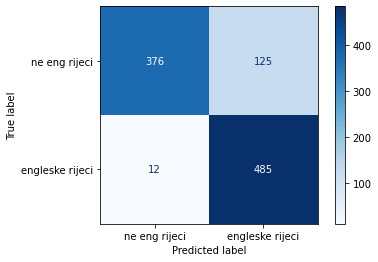

In [11]:
plot_confusion_matrix(
    model, ngram_test, klase_test,
    cmap=plt.cm.Blues,
    display_labels=['ne eng rijeci', 'engleske rijeci']);